In [1]:
import anatomist.api as ana
from soma.qt_gui.qtThread import QtThreadCall
from soma.qt_gui.qt_backend import Qt

a = ana.Anatomist()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
existing QApplication: 0
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-ad279118'


create qapp
global modules: /casa/host/build/share/anatomist-5.2/python_plugins
home   modules: /casa/home/.anatomist/python_plugins
done
Starting Anatomist.....
config file : /casa/home/.anatomist/config/settings.cfg
PyAnatomist Module present
PythonLauncher::runModules()
loading module simple_controls
loading module save_resampled
loading module selection
loading module bsa_proba
loading module modelGraphs
loading module profilewindow
loading module ana_image_math
loading module paletteViewer
loading module foldsplit
loading module anacontrolmenu
loading module gradientpalette
loading module palettecontrols
loading module meshsplit
loading module volumepalettes
loading module gltf_io
loading module infowindow
loading module histogram
loading module statsplotwindow
loading module valuesplotwindow
all python modules loaded
Anatomist started.


In [2]:
from soma import aims
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import umap
import os

## Embeddings and their associated z-score (after MOSTEST) for different regions of interest

### Region name

In [26]:
region_name = 'CINGULATE_right' #'CINGULATE_left' CINGULATE_right 'SC-sylv_right' 'ORBITAL_left' 'FIP_right' 'ORBITAL_right'
side = "R" # "R" or "L"
region = "CINGULATE" # "ORBITAL", "CINGULATE", "SC-sylv", "F.I.P."


path_to_most_results = '/volatile/ad279118/Irene/MOSTEST/Results/'
pre_residualized_bdd = pd.read_csv(f'{path_to_most_results}/{region_name}_pheno_pre_residualized.txt', sep='\t')
z_score = pd.read_csv(f'{path_to_most_results}/{region_name}_mostest_all_chr.most_orig.zmat.csv', sep='\t')

pre_residualized_bdd = pre_residualized_bdd.drop('#FID', axis=1)
pre_residualized_bdd = pre_residualized_bdd.set_index('IID')

### Get the direction given by the SNPs z-scores

In [27]:
print(pre_residualized_bdd.shape)
pre_residualized_bdd = pre_residualized_bdd[[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]
pre_residualized_bdd.iloc[:,:5].head()

(18117, 256)


,dim1,dim2,dim3,dim4,dim5
IID,,,,,
1000021,-0.195916,-0.304315,-1.115682,2.031291,0.998372
1000458,-0.554906,0.316802,-1.704059,0.738740,-0.099505
1000575,0.252104,0.945561,-1.397633,-0.100617,1.244446
1000606,0.737105,-2.323602,0.528787,0.494250,0.004843
1000963,0.132100,0.184363,0.141876,0.695263,0.413108


In [28]:
z_score = z_score[['CHR','SNP','PVAL']+[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]
z_score.iloc[:,:8].head()

,CHR,SNP,PVAL,dim1,dim2,dim3,dim4,dim5
0,15,rs199960021,1.330881e-08,2.118137,-0.210730,0.459156,0.596517,-1.212140
1,15,rs201092731,1.330881e-08,2.118137,-0.210730,0.459156,0.596517,-1.212140
2,15,rs78686176,4.947128e-11,-0.968599,-2.385193,-0.806529,-0.049075,0.853081
3,15,rs12594050,3.449310e-20,1.298688,0.125655,-1.391394,0.501433,0.991698
4,15,rs7164881,4.130895e-14,1.352868,-0.336757,1.035955,1.115657,-1.322278


In [29]:
#for 'CINGULATE_right' 
snp_dict = {'15 - rs7494898', '15 - rs6600055', '15 - rs576197712', '15 - rs538402926', '15 - rs4477654', '15 - rs4491484', '15 - rs79444661', '15 - rs7164881', '15 - rs6599955', '15 - rs138187386', '15 - rs143177198', '15 - rs6599923', '15 - rs2613454', '15 - rs10794636', '15 - rs2606035', '15 - rs569523843', '15 - rs200987510', '15 - rs7402221', '15 - rs1846735', '15 - rs373955846', '15 - rs8025114', '15 - rs10083705', '15 - rs7496889', '15 - rs147066741', '15 - rs7402220'}

#for 'CINGULATE_left'
#snp_dict = {'15 - rs143177198', '15 - rs10902996', '15 - rs8031849', '15 - rs6600055', '15 - rs6599955', '15 - rs139206070', '15 - rs11635272', '15 - rs200934108', '15 - rs67735421'}
#snp_dict = {'15 - rs4931967', '15 - rs4931966', '15 - rs111409649', '15 - rs376547578', '15 - rs4931969', '15 - rs4931968', '15 - rs4931965'}
#snp_dict = {'15 - rs62005845', '15 - rs202151238', '15 - rs12442925', '15 - rs2088769', '15 - rs12595302'}
#snp_dict = {'15 - rs6422232', '15 - rs6600017', '15 - rs28492761', '15 - rs6600031', '15 - rs6422231', '15 - rs6600022'}

#for 'ORBITAL_left'
#snp_dict = {'15 - rs202109518', '15 - rs1500470', '15 - rs6422232', '15 - rs6600017', '15 - rs28701172', '15 - rs28492761', '15 - rs6600031', '15 - rs6422231'}
#snp_dict = {'15 - rs3817039', '15 - rs7165870', '15 - rs6599868', '15 - rs4038410', '15 - rs4983846', '15 - rs4037969', '15 - rs1846742', '15 - rs2954579', '15 - rs6599879'}
#snp_dict = {'15 - rs201703530', '15 - rs58705825', '15 - rs79596784', '15 - rs200702320', '15 - rs9672855', '15 - rs4983851', '15 - rs9673043', '15 - rs73389804'}
#snp_dict = {'15 - rs6599961', '15 - rs4038998', '15 - rs2221193', '15 - rs2880567', '15 - rs1846749', '15 - rs1909786'}
#snp_dict = {'3 - rs9824378', '7 - rs10245919', '7 - rs10248814', '7 - rs17354412', '7 - rs7797751'}
#snp_dict = {'7 - rs1121732', '7 - rs4721797', '7 - rs3944043', '7 - rs7796617', '7 - rs4472417', '7 - rs6966112', '7 - rs2058423', '7 - rs6965709', '7 - rs4719573', '7 - rs7779144', '7 - rs1074858', '7 - rs60691938', '7 - rs4719575', '7 - rs2109873', '7 - rs1121731', '7 - rs28407069', '7 - rs1121734', '7 - rs4721794', '7 - rs28813981', '7 - rs10273311', '7 - rs9655168', '7 - rs2109874', '7 - rs28878824', '7 - rs28808719', '7 - rs7796085', '7 - rs11489333', '7 - rs7456896', '7 - rs10278512', '7 - rs10249288', '7 - rs4721802', '7 - rs4721798', '7 - rs7785608', '7 - rs2052207', '7 - rs4518562', '7 - rs7795929', '7 - rs1121733', '7 - rs10261832', '7 - rs17451868', '7 - rs9986862', '7 - rs4141046', '7 - rs28460797', '7 - rs10278898', '7 - rs12670744', '7 - rs28478330', '7 - rs4719571', '7 - rs10228147', '7 - rs7806003', '7 - rs4504538', '7 - rs35596058', '7 - rs4721801', '7 - rs7800812', '7 - rs10252608', '7 - rs10249487', '7 - rs4721799', '7 - rs2109876', '7 - rs4141045', '7 - rs1989540', '7 - rs4719574', '7 - rs4721793', '7 - rs7786991', '7 - rs7789003', '7 - rs4329170', '7 - rs12666412', '7 - rs2109877', '7 - rs62448110', '7 - rs9986695', '7 - rs1121730', '7 - rs7800139', '7 - rs2215634', '7 - rs7785223', '7 - rs4560698', '7 - rs10232959', '7 - rs2109872', '7 - rs7797567', '7 - rs10278656', '7 - rs10950740', '7 - rs10242068', '7 - rs4719572', '7 - rs4472416', '7 - rs2058422', '7 - rs4721790', '7 - rs9655175', '7 - rs7805758', '7 - rs12670713', '7 - rs10950738', '7 - rs4333484', '7 - rs2109875'}

#for 'ORBITAL_right'
#snp_dict = {'2 - rs3752663', '2 - rs2860911', '2 - rs3752664', '2 - rs13016586', '2 - rs2287283', '2 - rs79968190', '2 - rs10168499', '2 - rs1861771', '2 - rs2193469', '2 - rs12713548', '2 - rs6546176', '2 - rs6743531', '2 - rs2009778', '2 - rs2287286', '2 - rs888278', '2 - rs7580807', '2 - rs1541606', '2 - rs56213130', '2 - rs11126057', '2 - rs7576487', '2 - rs4233934', '2 - rs7600385', '2 - rs2111466', '2 - rs2287282', '2 - rs6546175', '2 - rs7559902', '2 - rs7562708', '2 - rs7570841'}
#snp_dict = {'7 - rs28526695', '7 - rs1121732', '7 - rs3944043', '7 - rs4721797', '7 - rs7796617', '7 - rs6965419', '7 - rs10242663', '7 - rs10244808', '7 - rs4472417', '7 - rs12537939', '7 - rs6966112', '7 - rs2058423', '7 - rs2192476', '7 - rs4721780', '7 - rs6945983', '7 - rs10807794', '7 - rs1476944', '7 - rs4719573', '7 - rs9648261', '7 - rs4721783', '7 - rs1074858', '7 - rs7779144', '7 - rs60691938', '7 - rs6963439', '7 - rs985307', '7 - rs4236296', '7 - rs4719575', '7 - rs7794428', '7 - rs13238033', '7 - rs7786622', '7 - rs4329169', '7 - rs2109873', '7 - rs2080222', '7 - rs1121731', '7 - rs10278135', '7 - rs55636616', '7 - rs28407069', '7 - rs1121734', '7 - rs4721794', '7 - rs28813981', '7 - rs10273311', '7 - rs13246869', '7 - rs12538102', '7 - rs9655168', '7 - rs9655174', '7 - rs985306', '7 - rs2390118', '7 - rs28583562', '7 - rs2109874', '7 - rs28878824', '7 - rs4721808', '7 - rs1158069', '7 - rs28808719', '7 - rs10486359', '7 - rs28441314', '7 - rs6949428', '7 - rs4480011', '7 - rs7796085', '7 - rs4719564', '7 - rs11489333', '7 - rs10229434', '7 - rs7456896', '7 - rs7796222', '7 - rs10278512', '7 - rs10249288', '7 - rs7802880', '7 - rs4236295', '7 - rs2160095', '7 - rs4721802', '7 - rs56203224', '7 - rs6971038', '7 - rs2024347', '7 - rs4719565', '7 - rs2192485', '7 - rs9648260', '7 - rs4721798', '7 - rs7789294', '7 - rs9655167', '7 - rs7785608', '7 - rs7809851', '7 - rs2390144', '7 - rs13437937', '7 - rs2192481', '7 - rs10244590', '7 - rs4337996', '7 - rs4719576', '7 - rs4721803', '7 - rs2052207', '7 - rs4518562', '7 - rs4602789', '7 - rs10257211', '7 - rs7795929', '7 - rs10261496', '7 - rs10232942', '7 - rs4721792', '7 - rs1121733', '7 - rs12536555', '7 - rs4721791', '7 - rs12700062', '7 - rs10261832', '7 - rs6461446', '7 - rs995182', '7 - rs17451868', '7 - rs2192486', '7 - rs11767221', '7 - rs9986862', '7 - rs7805790', '7 - rs4141046', '7 - rs10276556', '7 - rs4721778', '7 - rs2024355', '7 - rs10248814', '7 - rs7786609', '7 - rs28460797', '7 - rs10278898', '7 - rs12670744', '7 - rs7796341', '7 - rs28478330', '7 - rs2080017', '7 - rs7782309', '7 - rs4719571', '7 - rs4721807', '7 - rs12534570', '7 - rs4509205', '7 - rs10228147', '7 - rs4504538', '7 - rs7806003', '7 - rs4721784', '7 - rs4721801', '7 - rs7800812', '7 - rs4307235', '7 - rs10252608', '7 - rs12700063', '7 - rs10236102', '7 - rs12668384', '7 - rs995181', '7 - rs10249487', '7 - rs4721799', '7 - rs56302488', '7 - rs13438100', '7 - rs2109876', '7 - rs4141045', '7 - rs17354412', '7 - rs2390145', '7 - rs2109871', '7 - rs2192477', '7 - rs4721779', '7 - rs13438043', '7 - rs2390143', '7 - rs1989540', '7 - rs12700059', '7 - rs4719574', '7 - rs4721793', '7 - rs12700056', '7 - rs7786991', '7 - rs7789003', '7 - rs4329170', '7 - rs12666412', '7 - rs2109877', '7 - rs7797751', '7 - rs62448110', '7 - rs9986695', '7 - rs6461445', '7 - rs55883028', '7 - rs1121730', '7 - rs2215634', '7 - rs7800139', '7 - rs12668367', '7 - rs2109870', '7 - rs7785223', '7 - rs4560698', '7 - rs10232959', '7 - rs4721812', '7 - rs2109872', '7 - rs7797567', '7 - rs10278656', '7 - rs10950740', '7 - rs10242068', '7 - rs2390146', '7 - rs759249', '7 - rs4333484', '7 - rs4719572', '7 - rs4626493', '7 - rs10241336', '7 - rs7798205', '7 - rs10245919', '7 - rs10245106', '7 - rs10267686', '7 - rs4472416', '7 - rs4721809', '7 - rs57584385', '7 - rs2058422', '7 - rs9655175', '7 - rs12532587', '7 - rs7805758', '7 - rs10950739', '7 - rs7801835', '7 - rs4721806', '7 - rs12670713', '7 - rs10282612', '7 - rs10261834', '7 - rs10950738', '7 - rs4526253', '7 - rs10230207', '7 - rs714392', '7 - rs4721811', '7 - rs2390142', '7 - rs2109875', '7 - rs56229068'}

#for 'ORBITAL_left_2'
#snp_dict = {'15 - rs4931968', '15 - rs4931965', '15 - rs4931966', '15 - rs113432051', '15 - rs4931967'}
#snp_dict = {'15 - rs6600022', '15 - rs28492761', '15 - rs6600031', '15 - rs6422232', '15 - rs6422231', '15 - rs6600017'}
#snp_dict = {'2 - rs7570841', '2 - rs13015657', '2 - rs2860911', '2 - rs3815608', '2 - rs12997745', '2 - rs7580807', '2 - rs12465315', '2 - rs1541606', '2 - rs2287282', '2 - rs3752663', '2 - rs3752664', '2 - rs13008325', '2 - rs2287286', '2 - rs6546176', '2 - rs2287283', '2 - rs888278', '2 - rs2287281', '2 - rs12713549', '2 - rs2193463', '2 - rs17681189', '2 - rs2009778', '2 - rs56213130', '2 - rs6546178', '2 - rs1861771', '2 - rs6709906', '2 - rs6546175', '2 - rs7600385', '2 - rs12989218', '2 - rs3815606', '2 - rs2111466', '2 - rs4233934', '2 - rs13016586', '2 - rs13008718', '2 - rs7562708', '2 - rs12713548', '2 - rs10168499', '2 - rs1549022', '2 - rs79968190', '2 - rs7576487', '2 - rs7559902', '2 - rs6743531', '2 - rs11126057', '2 - rs2287287', '2 - rs7591503', '2 - rs7582307', '2 - rs7562620', '2 - rs7564837', '2 - rs6546177', '2 - rs2193465', '2 - rs3815605', '2 - rs3856523', '2 - rs2193466', '2 - rs7591972', '2 - rs6745682', '2 - rs2193469', '2 - rs2111464', '2 - rs11885674'}
#snp_dict = {'17 - rs7221399', '17 - rs6501447', '17 - rs737957', '17 - rs11657593', '17 - rs2190463', '17 - rs9893839', '17 - rs737959', '17 - rs62063939', '17 - rs10401004', '17 - rs9916542', '17 - rs737958', '17 - rs8075481', '17 - rs8079962', '17 - rs4793539', '17 - rs9901939', '17 - rs737956', '17 - rs6501462', '17 - rs9902909', '17 - rs917280', '17 - rs7209505', '17 - rs7214479', '17 - rs8067145'}
#snp_dict = {'7 - rs1121732', '7 - rs10278656', '7 - rs2080017', '7 - rs917919', '7 - rs4472417', '7 - rs7798205', '7 - rs7796341', '7 - rs10245106', '7 - rs10261832', '7 - rs9648261', '7 - rs6945983', '7 - rs12538102', '7 - rs4721809', '7 - rs62448110', '7 - rs6972245', '7 - rs4626493', '7 - rs995182', '7 - rs4721794', '7 - rs7796222', '7 - rs57584385', '7 - rs10276556', '7 - rs12670744', '7 - rs2024347', '7 - rs10248814', '7 - rs1476944', '7 - rs10278512', '7 - rs4721797', '7 - rs58473162', '7 - rs10261496', '7 - rs10249288', '7 - rs2109876', '7 - rs1121730', '7 - rs28813981', '7 - rs12700063', '7 - rs11489333', '7 - rs1121731', '7 - rs4721780', '7 - rs6461446', '7 - rs4307235', '7 - rs4721806', '7 - rs2390118', '7 - rs60691938', '7 - rs2109870', '7 - rs917917', '7 - rs9655174', '7 - rs10244808', '7 - rs7785608', '7 - rs10261834', '7 - rs2390143', '7 - rs7806003', '7 - rs1074858', '7 - rs4602789', '7 - rs28460797', '7 - rs11767221', '7 - rs9655167', '7 - rs10950738', '7 - rs6965419', '7 - rs6971038', '7 - rs12534570', '7 - rs9986695', '7 - rs10273311', '7 - rs7795929', '7 - rs7782309', '7 - rs4719571', '7 - rs4329170', '7 - rs57176772', '7 - rs9648260', '7 - rs2192477', '7 - rs7796617', '7 - rs10950740', '7 - rs2024355', '7 - rs10242663', '7 - rs4509205', '7 - rs4236295', '7 - rs28441314', '7 - rs4721808', '7 - rs4570042', '7 - rs2109871', '7 - rs12700057', '7 - rs4719575', '7 - rs7805758', '7 - rs10229434', '7 - rs12532587', '7 - rs7805790', '7 - rs7794428', '7 - rs2390145', '7 - rs4721779', '7 - rs4721798', '7 - rs7801835', '7 - rs1121734', '7 - rs2109874', '7 - rs12537939', '7 - rs2052207', '7 - rs4518562', '7 - rs56203224', '7 - rs10486359', '7 - rs10249487', '7 - rs55883028', '7 - rs4721802', '7 - rs2192486', '7 - rs2109873', '7 - rs7786991', '7 - rs7800139', '7 - rs7789868', '7 - rs9655168', '7 - rs4470914', '7 - rs17451868', '7 - rs10232959', '7 - rs2192476', '7 - rs759248', '7 - rs6965709', '7 - rs7779144', '7 - rs12700056', '7 - rs28526695', '7 - rs4721792', '7 - rs28407069', '7 - rs2390146', '7 - rs917918', '7 - rs2058422', '7 - rs759249', '7 - rs12700059', '7 - rs10807794', '7 - rs2192485', '7 - rs10252608', '7 - rs4719564', '7 - rs2215634', '7 - rs7456896', '7 - rs7789003', '7 - rs10230207', '7 - rs56229068', '7 - rs4141045', '7 - rs12700062', '7 - rs4236296', '7 - rs2192484', '7 - rs7797567', '7 - rs2109872', '7 - rs2058423', '7 - rs4141046', '7 - rs4721793', '7 - rs10950739', '7 - rs4719565', '7 - rs10269875', '7 - rs4560698', '7 - rs10244590', '7 - rs7796085', '7 - rs4719574', '7 - rs9655175', '7 - rs7797751', '7 - rs10282612', '7 - rs4472416', '7 - rs10230658', '7 - rs2109875', '7 - rs28583562', '7 - rs1989540', '7 - rs7809851', '7 - rs7786622', '7 - rs13438043', '7 - rs4721801', '7 - rs12670713', '7 - rs12668367', '7 - rs4721783', '7 - rs13246869', '7 - rs7789294', '7 - rs10267686', '7 - rs10241336', '7 - rs13238033', '7 - rs9986862', '7 - rs2109877', '7 - rs4721807', '7 - rs4504538', '7 - rs12666412', '7 - rs28478330', '7 - rs6461445', '7 - rs4721778', '7 - rs4719576', '7 - rs10232942', '7 - rs17354370', '7 - rs4721811', '7 - rs3944043', '7 - rs28808719', '7 - rs2160095', '7 - rs28878824', '7 - rs10245919', '7 - rs4333484', '7 - rs4721803', '7 - rs6963439', '7 - rs985307', '7 - rs6966112', '7 - rs4526253', '7 - rs1121733', '7 - rs10278898', '7 - rs10236102', '7 - rs1158069', '7 - rs56302488', '7 - rs2390142', '7 - rs10228147', '7 - rs10278135', '7 - rs28882744', '7 - rs55636616', '7 - rs7786609', '7 - rs4337996', '7 - rs13438100', '7 - rs7785223', '7 - rs2080222', '7 - rs995181', '7 - rs2390144', '7 - rs4329169', '7 - rs7800812', '7 - rs4719572', '7 - rs4480011', '7 - rs4721791', '7 - rs6949428', '7 - rs13437937', '7 - rs10257211', '7 - rs7802880', '7 - rs4721799', '7 - rs714392', '7 - rs4719573', '7 - rs12536555', '7 - rs2192481', '7 - rs10242068', '7 - rs4721812', '7 - rs12668384', '7 - rs17354412', '7 - rs4721784'}


#for 'SC-sylv_right'
#snp_dict = {'15 - rs7165870', '15 - rs573931406', '15 - rs562049825', '15 - rs2722118', '15 - rs4037969', '15 - rs1846742', '15 - rs11248748', '15 - rs6599879'}
#snp_dict = {'15 - rs200287473', '15 - rs7162161', '15 - rs6599943', '15 - rs28840813', '15 - rs6599942'}
#snp_dict = {'15 - rs4924346', '15 - rs16968662', '15 - rs4923822', '15 - rs3973350', '15 - rs62002282', '15 - rs7167869', '15 - rs72722959', '15 - rs145172346', '15 - rs7171648', '15 - rs72722978', '15 - rs3892720', '15 - rs11639391', '15 - rs17694988', '15 - rs12591944', '15 - rs8033007', '15 - rs10851385', '15 - rs12592015', '15 - rs8025239', '15 - rs10520128', '15 - rs2033939', '15 - rs3910644', '15 - rs10851383', '15 - rs16968876', '15 - rs2119403', '15 - rs34680120', '15 - rs16968890', '15 - rs1440802', '15 - rs11070193', '15 - rs3910645', '15 - rs11070189', '15 - rs9302101', '15 - rs8036794', '15 - rs16968739', '15 - rs4924345', '15 - rs8041440', '15 - rs8032326', '15 - rs66497604', '15 - rs3892721', '15 - rs62002283', '15 - rs7174403', '15 - rs56113415', '15 - rs4506868', '15 - rs1080066', '15 - rs11638679', '15 - rs71471500', '15 - rs59203590', '15 - rs56214701', '15 - rs11629938', '15 - rs11638016', '15 - rs8038768', '15 - rs7182018', '15 - rs28520337', '15 - rs56003663', '15 - rs1837636', '15 - rs4566132', '15 - rs139801643', '15 - rs12595360', '15 - rs11070185', '15 - rs10152323', '15 - rs62002285', '15 - rs4328411', '15 - rs72722976'}
#snp_dict = {'6 - rs9345124', '6 - rs4706392', '6 - rs2207617', '6 - rs9353816', '6 - rs9351259', '6 - rs9353817', '6 - rs4706391', '6 - rs9359935', '6 - rs6923112', '6 - rs9342271', '6 - rs9345125', '6 - rs4707671', '6 - rs2180127'}

#for 'SC-sylv_left'
#snp_dict = {'15 - rs7182018', '15 - rs16968739', '15 - rs62002283', '15 - rs56003663', '15 - rs71471500', '15 - rs59203590', '15 - rs56214701', '15 - rs62002285', '15 - rs4924346', '15 - rs62002282', '15 - rs10520128', '15 - rs2033939', '15 - rs11070185', '15 - rs72722978', '15 - rs4924345', '15 - rs4923822', '15 - rs56113415', '15 - rs4566132', '15 - rs11638016', '15 - rs7171648', '15 - rs11629938', '15 - rs12592015', '15 - rs8032326', '15 - rs28520337', '15 - rs1837636', '15 - rs3973350', '15 - rs12595360', '15 - rs34680120', '15 - rs1440802', '15 - rs17694988', '15 - rs1080066', '15 - rs8033007', '15 - rs10851383', '15 - rs2343893', '15 - rs10851385', '15 - rs72722959', '15 - rs8025239', '15 - rs4506868', '15 - rs12591944', '15 - rs4328411', '15 - rs11639391'}
#snp_dict = {'15 - rs7165870', '15 - rs1500469', '15 - rs11631172', '15 - rs62000532', '15 - rs1006435'}
#snp_dict = {'12 - rs7311862', '12 - rs3782659', '12 - rs3782652', '12 - rs7309747', '12 - rs1860957', '12 - rs2277403'}

# for 'FIP_right'
#snp_dict = {'14 - rs17255332', '14 - rs55649771', '14 - rs56115079', '14 - rs76674533', '14 - rs17255311', '14 - rs75255901', '14 - rs112195026', '14 - rs143720575', '14 - rs73313052', '14 - rs79360654', '14 - rs2164950', '14 - rs8005394', '14 - rs79814107', '14 - rs4901898', '14 - rs17833752', '14 - rs74826997', '14 - rs117461235', '14 - rs72724702', '14 - rs4901902', '14 - rs4901906', '14 - rs76341705', '14 - rs77618329', '14 - rs113269922', '14 - rs76787422', '14 - rs76850797', '14 - rs78580207', '14 - rs17255395', '14 - rs77168169', '14 - rs4901904', '14 - rs76256424', '14 - rs78032956', '14 - rs79676525', '14 - rs78349529', '14 - rs10498489', '14 - rs72726305', '14 - rs78419480', '14 - rs17255304'}
#snp_dict = {'6 - rs4895532', '6 - rs4620141', '6 - rs4314513', '6 - rs9399243', '6 - rs4896374', '6 - rs11758715', '6 - rs4243455', '6 - rs4481452', '6 - rs4895531', '6 - rs6903242', '6 - rs4243453', '6 - rs12200595', '6 - rs4895534', '6 - rs10457671', '6 - rs9399244', '6 - rs4895533', '6 - rs9389588', '6 - rs9376354', '6 - rs9402980', '6 - rs4131177', '6 - rs9399246', '6 - rs9399245', '6 - rs7742292', '6 - rs9399247', '6 - rs4896372'}
#snp_dict = {'3 - rs73149103', '3 - rs60759140', '3 - rs73139302', '3 - rs7632502', '3 - rs73139281', '3 - rs73139105', '3 - rs73141108', '3 - rs12152372', '3 - rs73139115', '3 - rs12634269', '3 - rs73139121', '3 - rs7637670', '3 - rs1499780', '3 - rs73139125', '3 - rs2117138', '3 - rs2346840', '3 - rs1157608', '3 - rs73139286', '3 - rs73139257', '3 - rs7635916', '3 - rs2117136', '3 - rs7613412', '3 - rs112087049', '3 - rs3792572', '3 - rs12634341', '3 - rs73139104', '3 - rs113141104', '3 - rs7637504', '3 - rs7652296', '3 - rs7626735', '3 - rs73139290', '3 - rs6795325', '3 - rs112335559', '3 - rs1912966', '3 - rs17027018', '3 - rs1520596', '3 - rs7632427', '3 - rs11918555', '3 - rs73139127', '3 - rs59381722', '3 - rs73139147', '3 - rs2117137', '3 - rs73139135', '3 - rs67316928', '3 - rs35968370', '3 - rs73139288', '3 - rs73139144', '3 - rs59541469', '3 - rs35124509', '3 - rs724972', '3 - rs987748', '3 - rs73146988', '3 - rs6795074', '3 - rs73139119', '3 - rs6551415', '3 - rs1054750', '3 - rs73137395', '3 - rs73139134', '3 - rs73139284', '3 - rs73145338', '3 - rs73141113', '3 - rs73139276', '3 - rs17026944', '3 - rs73153219', '3 - rs12637608', '3 - rs7653735', '3 - rs1512183', '3 - rs11921985', '3 - rs12629165', '3 - rs7621573', '3 - rs2346836', '3 - rs73141104', '3 - rs10511145', '3 - rs1157607', '3 - rs73139131', '3 - rs11925143', '3 - rs7650466', '3 - rs73139117', '3 - rs73139133', '3 - rs17801380', '3 - rs66499884', '3 - rs6772953', '3 - rs7650184', '3 - rs6771054', '3 - rs12631313', '3 - rs7616322', '3 - rs73139296', '3 - rs6551412', '3 - rs2881488', '3 - rs12636275', '3 - rs73139110', '3 - rs73139118', '3 - rs73139148', '3 - rs7633500', '3 - rs3762717', '3 - rs1912965', '3 - rs73139129', '3 - rs73139139', '3 - rs73149107', '3 - rs6551413', '3 - rs60243237', '3 - rs12636710', '3 - rs66757381'}

# for 'FIP_left'
#snp_dict = {'15 - rs573931406', '15 - rs4037969', '15 - rs1846742', '15 - rs6599879', '15 - rs562049825'}
#snp_dict = {'15 - rs73389804', '15 - rs200702320', '15 - rs79596784', '15 - rs72622077', '15 - rs201703530'}
#snp_dict = {'14 - rs72724697', '14 - rs72726305', '14 - rs2164950', '14 - rs76787422', '14 - rs74826997', '14 - rs117461235', '14 - rs79360654', '14 - rs8005394', '14 - rs73313052', '14 - rs17833752', '14 - rs4901902', '14 - rs112195026', '14 - rs76850797', '14 - rs76256424', '14 - rs72724695', '14 - rs4901904', '14 - rs4901898', '14 - rs77168169', '14 - rs76674533', '14 - rs79676525', '14 - rs78349529', '14 - rs17255332', '14 - rs78580207', '14 - rs78032956', '14 - rs17255304', '14 - rs28673301', '14 - rs1438521', '14 - rs143720575', '14 - rs10498487', '14 - rs4901906', '14 - rs55649771', '14 - rs10498489', '14 - rs17255395', '14 - rs75255901', '14 - rs113269922', '14 - rs76341705', '14 - rs17095819', '14 - rs72724702', '14 - rs56115079', '14 - rs17255311', '14 - rs77618329', '14 - rs79814107'}
 
# for 'STi-STs-STpol_left'
#snp_dict = {'2 - rs881495', '2 - rs34118104', '2 - rs12615848', '2 - rs12615999', '2 - rs13035861', '2 - rs7607297', '2 - rs7606896', '2 - rs11682355', '2 - rs13026041', '2 - rs6751411', '2 - rs4667347', '2 - rs13011264', '2 - rs10930572', '2 - rs16826589', '2 - rs35537026', '2 - rs35397906', '2 - rs12621827', '2 - rs7609463', '2 - rs12992560', '2 - rs756443', '2 - rs13006546', '2 - rs6751737', '2 - rs11684511', '2 - rs6737636', '2 - rs13004145', '2 - rs7594794', '2 - rs6730642'}

# for 'STs_right'
# snp_dict = {'2 - rs881495', '2 - rs12615848', '2 - rs12615999', '2 - rs13035861', '2 - rs11674257', '2 - rs7607297', '2 - rs7606896', '2 - rs11682355', '2 - rs4667347', '2 - rs13011264', '2 - rs16826589', '2 - rs35397906', '2 - rs12621827', '2 - rs7609463', '2 - rs10930684', '2 - rs12992560', '2 - rs756443', '2 - rs13006546', '2 - rs6751737', '2 - rs11673945', '2 - rs11684511', '2 - rs6737636', '2 - rs13004145', '2 - rs7594794', '2 - rs8179684', '2 - rs6730642', '2 - rs11676178'}
# snp_dict = {'15 - rs376686351', '15 - rs117444554', '15 - rs113432051', '15 - rs4931967', '15 - rs4931966', '15 - rs376547578', '15 - rs4931965', '15 - rs4931968'}

# for 'STs_left'
# snp_dict = {'2 - rs34210632', '2 - rs10754978', '2 - rs678915', '2 - rs10930474', '2 - rs12615999', '2 - rs13011264', '2 - rs16826589', '2 - rs678484', '2 - rs7607297', '2 - rs7594794', '2 - rs7606896', '2 - rs6730642', '2 - rs6751411', '2 - rs7609463', '2 - rs10930472', '2 - rs6737636'}
# snp_dict =  {'14 - rs7141553', '14 - rs11625492', '14 - rs12147351', '14 - rs9323338', '14 - rs10498488', '14 - rs10151194'}

# Convert dictionary to a DataFrame for easier comparison
snp_df = pd.DataFrame(list(snp_dict), columns=['SNP'])
snp_df[['CHR', 'SNP']] = snp_df['SNP'].str.split(' - ', expand=True)
snp_df['CHR'] = snp_df['CHR'].astype(int)

# Now filter the z_score DataFrame
filtered_z_score = z_score[z_score['CHR'].isin(snp_df['CHR']) & z_score['SNP'].isin(snp_df['SNP'])]

# Compute the average of each column, excluding 'CHR' and 'SNP'
average_values = filtered_z_score.drop(['CHR', 'SNP'], axis=1).mean()

print("Average Values:")
print(average_values)

Average Values:
PVAL      1.391463e-09
dim1     -2.857120e-01
dim2      6.694473e-02
dim3     -2.599797e-01
dim4     -2.126611e-01
              ...     
dim252    8.279382e-02
dim253   -1.948906e-01
dim254   -1.405726e-01
dim255   -2.105695e-02
dim256   -5.942932e-02
Length: 257, dtype: float64


In [30]:
{snp.replace('7 - ', '') for snp in snp_dict}

{'15 - rs10083705',
 '15 - rs10794636',
 '15 - rs138187386',
 '15 - rs143177198',
 '15 - rs147066741',
 '15 - rs1846735',
 '15 - rs200987510',
 '15 - rs2606035',
 '15 - rs2613454',
 '15 - rs373955846',
 '15 - rs4477654',
 '15 - rs4491484',
 '15 - rs538402926',
 '15 - rs569523843',
 '15 - rs576197712',
 '15 - rs6599923',
 '15 - rs6599955',
 '15 - rs6600055',
 '15 - rs7164881',
 '15 - rs7402220',
 '15 - rs7402221',
 '15 - rs7494898',
 '15 - rs7496889',
 '15 - rs79444661',
 '15 - rs8025114'}

In [31]:
def project(direction, latent=pre_residualized_bdd):
    # Compute the dot product of each row in pre_residualized_bdd with heriditary_direction
    # This calculates np.dot(a, heriditary_vector) for each row `a` in `pre_residualized_bdd`.
    dot_products = latent.apply(lambda row: np.dot(row, direction), axis=1)

    # Compute the norm squared of heriditary_vector,
    direction = np.dot(direction, direction)

    # Calculate the projections
    projections = dot_products / direction

    # Sort the series by the projection values
    sorted_projections = projections.sort_values(ascending=False)

    # Display the sorted series
    #print(sorted_projections)
    return sorted_projections

In [32]:
heriditary_direction = average_values.drop(['PVAL'], axis=0).to_numpy()
heriditary_direction = heriditary_direction.flatten()
sorted_projections = project(heriditary_direction, pre_residualized_bdd)

In [33]:
def plot_figure():
    import matplotlib.pyplot as plt
    %matplotlib widget

    list_std=[]
    list_direction_name=[]

    plt.figure(figsize=(24,8))
    plt.subplot(1,2,1)
    sorted_projections.hist(bins=100, alpha=0.8, label=f'SNPs direction', color='salmon')
    list_std.append(sorted_projections.std())
    list_direction_name.append('SNP')

    for i in range(100):
        random_direction = np.random.randn(256) # to test a random direction
        sorted_rd_projections = project(random_direction, pre_residualized_bdd)
        sorted_rd_projections.hist(bins=100, alpha=0.1, color='mediumslateblue') # , label=f'Random direction {i}')
        list_std.append(sorted_rd_projections.std())
        list_direction_name.append(f'Random {i}')
        

    plt.ylabel('Nb of subject')
    plt.xlabel('Projected position on the direction')
    plt.title('Distribution of projected subject on a given direction')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(list_std[0], list_direction_name[0], color='salmon')
    plt.scatter(list_std[1:],list_direction_name[1:], color='mediumslateblue')
    plt.xlabel('STD')
    plt.yticks([i for i in range(0,len(list_direction_name),len(list_direction_name)//10)])
    plt.ylabel('Direction')
    plt.show()

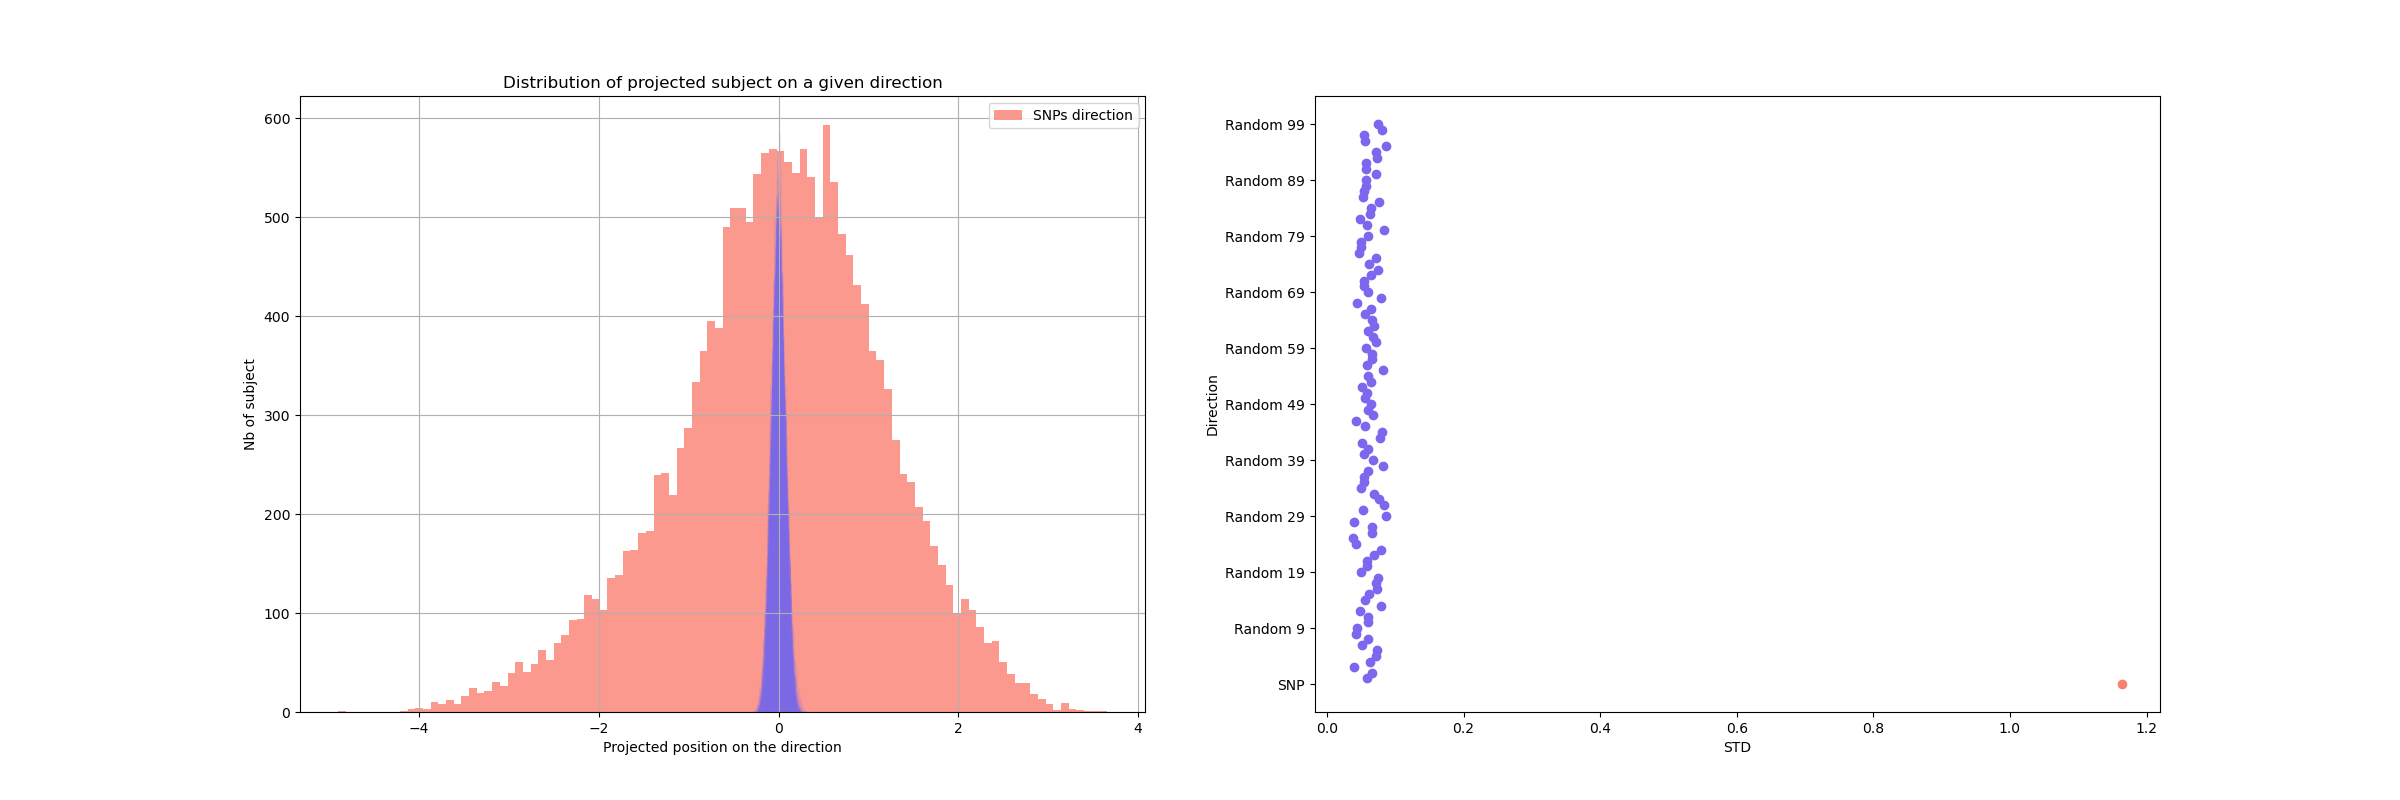

: 

In [38]:
#plot_figure()

## Visualization

In [34]:
def to_bucket(obj):
    if obj.type() == obj.BUCKET:
        return obj
    avol = a.toAimsObject(obj)
    c = aims.Converter(intype=avol, outtype=aims.BucketMap_VOID)
    abck = c(avol)
    bck = a.toAObject(abck)
    bck.releaseAppRef()
    return bck

def build_gradient(pal):
    gw = ana.cpp.GradientWidget(None, 'gradientwidget', pal.header()['palette_gradients'])
    gw.setHasAlpha(True)
    nc = pal.shape[0]
    rgbp = gw.fillGradient(nc, True)
    rgb = rgbp.data()
    npal = pal.np['v']
    pb = np.frombuffer(rgb, dtype=np.uint8).reshape((nc, 4))
    npal[:, 0, 0, 0, :] = pb
    npal[:, 0, 0, 0, :3] = npal[:, 0, 0, 0, :3][:, ::-1]  # BGRA -> RGBA
    pal.update()

def buckets_average(subject_id_list, dataset_name_list):
    dic_vol = {}
    dim = 0
    rep = 0
    if len(subject_id_list) == 0:
        return False
    while dim == 0 and rep < len(subject_id_list):
        if dataset_name_list[rep].lower() in ['ukb', 'ukbiobank', 'projected_ukb']:
            dataset = 'UkBioBank'
        mm_skeleton_path = f"/neurospin/dico/data/deep_folding/current/datasets/{dataset}/crops/2mm/{region}/mask/{side}crops"
        if os.path. isfile(f'{mm_skeleton_path}/{subject_id_list[rep]}_cropped_skeleton.nii.gz'):
            sum_vol = aims.read(f'{mm_skeleton_path}/{subject_id_list[rep]}_cropped_skeleton.nii.gz').astype(float)
            dim = sum_vol.shape
            sum_vol.fill(0)
        else: 
            print(f'FileNotFound {mm_skeleton_path}/{subject_id_list[rep]}_cropped_skeleton.nii.gz')
            #raise FileNotFoundError(f'{mm_skeleton_path}/{subject_id_list[0]}_cropped_skeleton.nii.gz')
        rep += 1

    for subject_id, dataset in zip(subject_id_list,dataset_name_list):
        if dataset.lower() in ['ukb', 'ukbiobank',  'projected_ukb']:
            dataset = 'UkBioBank'
        elif dataset.lower() == 'hcp':
            dataset = 'hcp'
            
        mm_skeleton_path = f"/neurospin/dico/data/deep_folding/current/datasets/{dataset}/crops/2mm/{region}/mask/{side}crops"

        if os.path. isfile(f'{mm_skeleton_path}/{subject_id}_cropped_skeleton.nii.gz'):
            vol = aims.read(f'{mm_skeleton_path}/{subject_id}_cropped_skeleton.nii.gz')
            # compare the dim with the first file dim

            if vol.np.shape != dim:
                raise ValueError(f"{subject_id_list[0]} and {subject_id} must have the same dim")

                
            # to have a binary 3D structure
            dic_vol[subject_id] = (vol.np > 0).astype(int)
            sum_vol.np[:] += (vol.np > 0).astype(int) 
        else: 
            print(f'FileNotFound {mm_skeleton_path}/{subject_id}_cropped_skeleton.nii.gz')
            #raise FileNotFoundError(f'{mm_skeleton_path}/{subject_id}_cropped_skeleton.nii.gz')

    sum_vol = sum_vol / len(subject_id_list)
    print(sum_vol, sum_vol.shape)
    return sum_vol

In [35]:
average_dic = {}
nb_columns = 10
block = a.createWindowsBlock(nb_columns)

In [36]:
step = 200
dic_packages = {}
for i in range(0,len(sorted_projections),step):
    list_idx = (sorted_projections.index[i:i+step].to_numpy())
    dic_packages[i//step] = [f'sub-{idx}' for idx in list_idx] 
list_database = ['UkBioBank' for i in range(step)]
n_pack = len(dic_packages)

In [37]:
#for i in ([k for k in range(10)]+[k for k in range(n_pack//2-5,n_pack//2+5)]+[k for k in range(n_pack-10,n_pack)]):
for i in range(0,n_pack, n_pack//30):
    sum_vol = buckets_average(dic_packages[i], list_database)
    average_dic[f'a_sum_vol{i}'] = a.toAObject(sum_vol)
    average_dic[f'a_sum_vol{i}'].setPalette(minVal=0, absoluteMode=True)
    #wsum = a.createWindow('Sagittal', block=block)
    #wsum.addObjects(a_sum_vol)
    average_dic[f'rvol{i}'] = a.fusionObjects(objects=[average_dic[f'a_sum_vol{i}']], method='VolumeRenderingFusionMethod')
    average_dic[f'rvol{i}'].releaseAppRef()
    # custom palette
    n = len(dic_packages[i])
    pal = a.createPalette('VR-palette')
    pal.header()['palette_gradients'] = '0;0.459574;0.497872;0.910638;1;1#0;0;0.52766;0.417021;1;1#0;0.7;1;0#0;0;0.0297872;0.00851064;0.72766;0.178723;0.957447;0.808511;1;1'
    #f'0;0.244444;0.5;1;1;1#0;0;0.535897;0.222222;1;1#0;0.7;1;0#0;0;{0.5/n};0;1;1'
    build_gradient(pal)
    average_dic[f'rvol{i}'].setPalette('VR-palette', minVal=0.05, absoluteMode=True)
    pal2 = a.createPalette('slice-palette')
    pal2.header()['palette_gradients'] = '0;0.459574;0.497872;0.910638;1;1#0;0;0.52766;0.417021;1;1#0;0.7;1;0#0;0;0.0297872;0.00851064;0.72766;0.178723;0.957447;0.808511;1;1'
    #f'0;0.244444;0.5;1;1;1#0;0;0.535897;0.222222;1;1#0;0.7;1;0#0;0;{0.3/n};0;{0.7/n};1;1;1'
    build_gradient(pal2)
    average_dic[f'a_sum_vol{i}'].setPalette('slice-palette')
    # rvol.palette().fill()
    average_dic[f'wvr{i}'] = a.createWindow('3D', block=block)
    average_dic[f'wvr{i}'].addObjects(average_dic[f'rvol{i}'])

<soma.aims.Volume_DOUBLE object at 0x763a52fe8af0> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a52febac0> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a80f2e0> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a80ecb0> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a7a5e10> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a7a5630> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a7f0790> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a7f1bd0> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a80eef0> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a800790> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a801240> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a784b80> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a791d80> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a791090> (16, 37, 37, 1)
<soma.aims.Volume_DOUBLE object at 0x763a5a7ad000> (16, 37, 37

no position could be read at -1, 181
no position could be read at 92, 17
no position could be read at 72, 10
no position could be read at 134, 138
no position could be read at 116, 168
no position could be read at 40, 203


SetObjectPaletteCommand : warning: palette "CustomGradient" not found


no position could be read at 142, 173
no position could be read at 119, 206
